In [11]:
pip install pandas_datareader

Note: you may need to restart the kernel to use updated packages.


In [12]:
import pandas as pd
import pandas_datareader.data as web
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
plt.style.use('fivethirtyeight')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [13]:
btc = web.get_data_yahoo('BTC-USD', start=datetime.datetime(2017, 1, 1), end=datetime.datetime(2019, 8, 7))
btc.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2017-01-01,1001.609985,956.099976,963.380005,995.440002,40570922,995.440002
2017-01-02,1031.680054,990.200012,995.440002,1017.049988,66038073,1017.049988
2017-01-03,1035.469971,1006.530029,1017.049988,1033.300049,56085870,1033.300049
2017-01-04,1148.540039,1022.320007,1033.300049,1135.410034,170584623,1135.410034
2017-01-05,1150.630005,874.530029,1135.410034,989.349976,244839289,989.349976


In [14]:
np.sum(btc['Close'] - btc['Adj Close'])

0.0

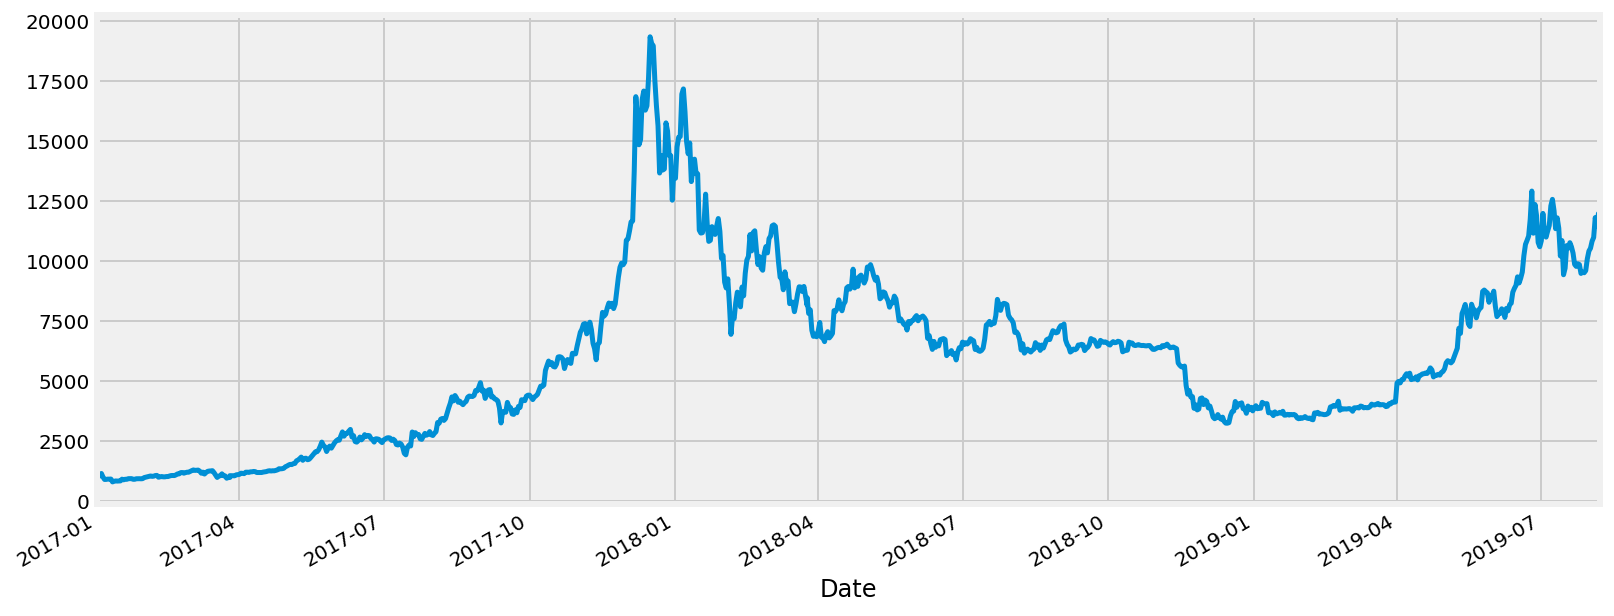

In [15]:
btc_adj = btc['Adj Close']
btc_adj.plot(lw=2.5, figsize=(12, 5))
plt.show()

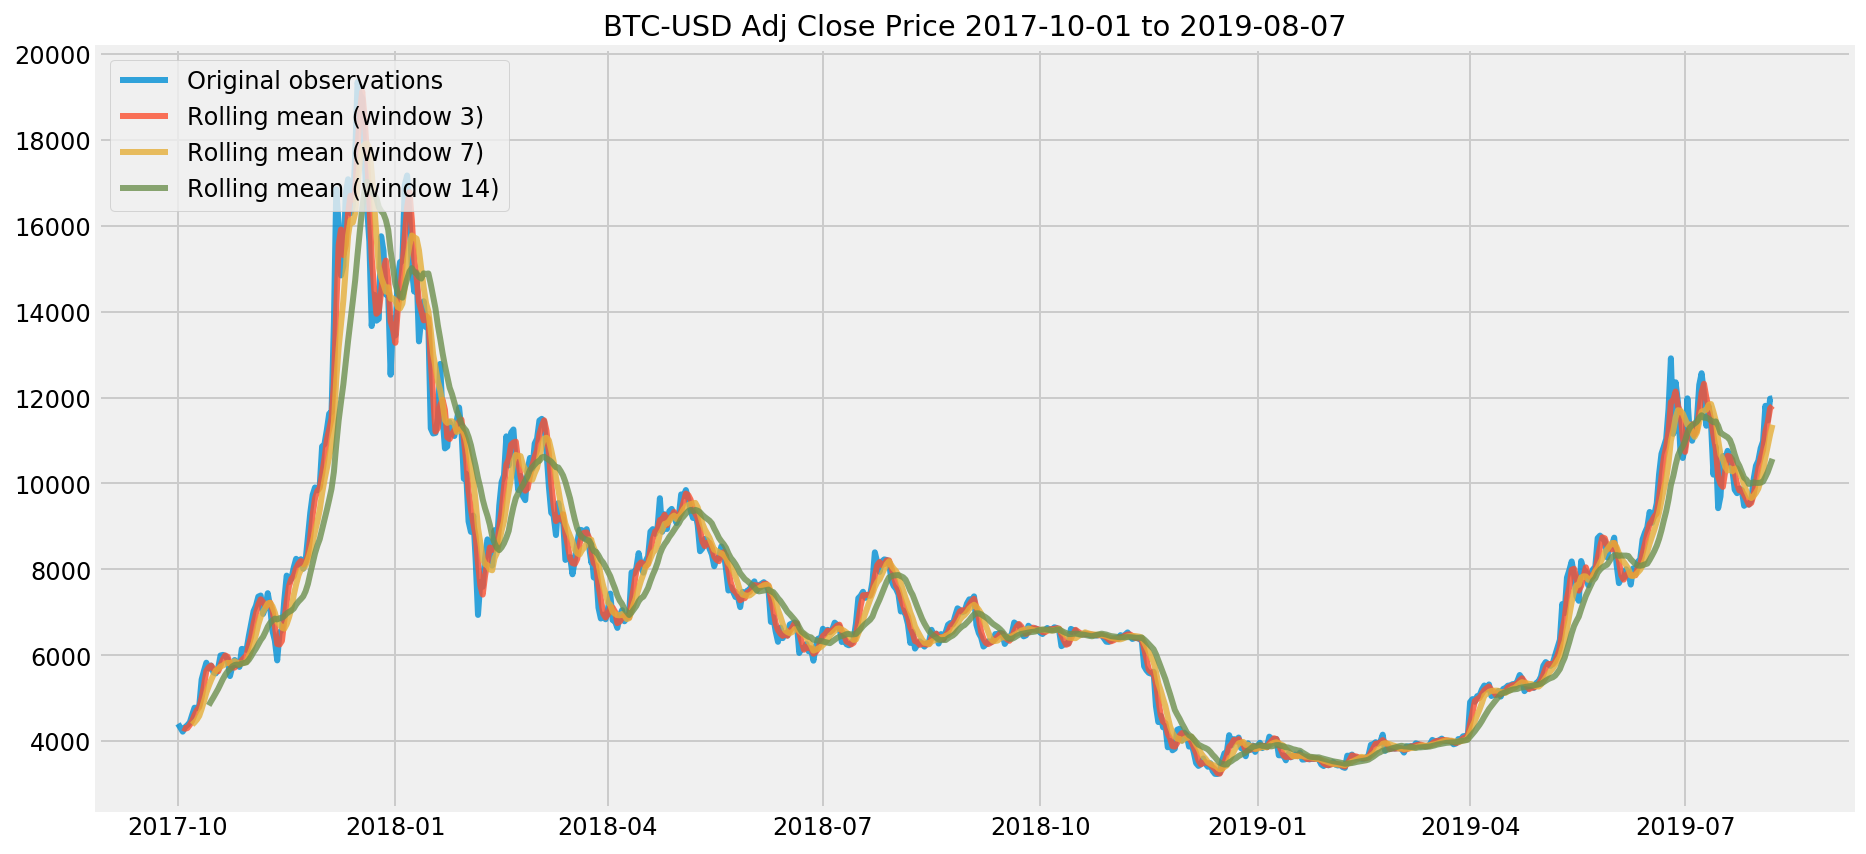

In [16]:
#Let’s see how moving average works on a graph by plotting price data from 01/10/2017 to 27/12/2019. 
btc_recent = btc_adj.loc['2017-10-01':'2019-08-07']
rroll_d3 = btc_recent.rolling(window=3).mean()
rroll_d7 = btc_recent.rolling(window=7).mean()
rroll_d14 = btc_recent.rolling(window=14).mean()
plt.figure(figsize=(14, 7))
plt.plot(btc_recent.index, btc_recent, lw=3, alpha=0.8,label='Original observations')
plt.plot(btc_recent.index, rroll_d3, lw=3, alpha=0.8,label='Rolling mean (window 3)')
plt.plot(btc_recent.index, rroll_d7, lw=3, alpha=0.8,label='Rolling mean (window 7)')
plt.plot(btc_recent.index, rroll_d14, lw=3, alpha=0.8,label='Rolling mean (window 14)')
plt.title('BTC-USD Adj Close Price 2017-10-01 to 2019-08-07')
plt.tick_params(labelsize=12)
plt.legend(loc='upper left', fontsize=12)
plt.show()

In [17]:
short_window = 10
mid_window = 50
signals = pd.DataFrame(index=btc_adj.index)
signals['signal'] = 0.0
roll_d10 = btc_adj.rolling(window=short_window).mean()
roll_d50 = btc_adj.rolling(window=mid_window).mean()
signals['short_mavg'] = roll_d10
signals['mid_mavg'] = roll_d50
signals['signal'][short_window:] = np.where(signals['short_mavg'][short_window:] > signals['mid_mavg'][short_window:], 1.0, 0.0)
signals['positions'] = signals['signal'].diff()

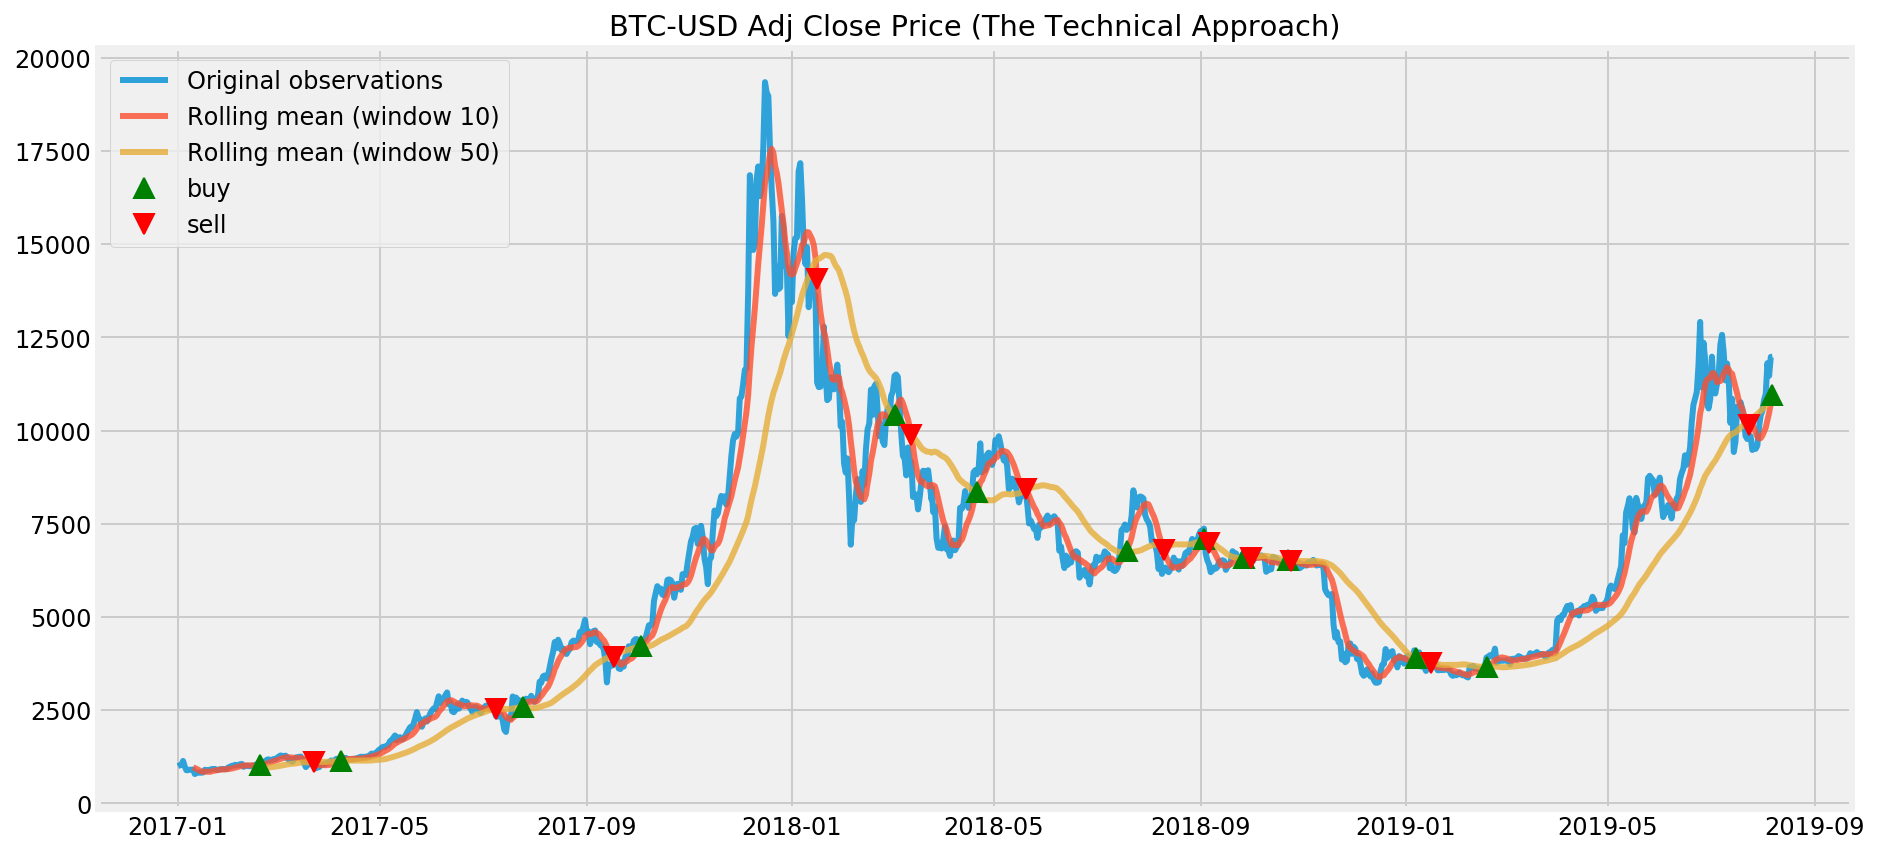

In [18]:
plt.figure(figsize=(14, 7))
plt.plot(btc_adj.index, btc_adj, lw=3, alpha=0.8,label='Original observations')
plt.plot(btc_adj.index, roll_d10, lw=3, alpha=0.8,label='Rolling mean (window 10)')
plt.plot(btc_adj.index, roll_d50, lw=3, alpha=0.8,label='Rolling mean (window 50)')
plt.plot(signals.loc[signals.positions == 1.0].index, 
         signals.short_mavg[signals.positions == 1.0],
         '^', markersize=10, color='g', label='buy')
         
plt.plot(signals.loc[signals.positions == -1.0].index, 
         signals.short_mavg[signals.positions == -1.0],
         'v', markersize=10, color='r', label='sell')
plt.title('BTC-USD Adj Close Price (The Technical Approach)')
plt.tick_params(labelsize=12)
plt.legend(loc='upper left', fontsize=12)
plt.show()

In [19]:
initial_investment = btc_adj.loc[list(signals[signals.positions == 1.0].index)][0]
bought = np.sum(btc_adj.loc[list(signals[signals.positions == 1.0].index)]*-1.0)
sold = np.sum(btc_adj.loc[list(signals[signals.positions == -1.0].index)])
current_btc_value = btc_adj[-1]
balance = pd.DataFrame([btc_adj.loc[list(signals[signals.positions == 1.0].index)]*-1.0,
              btc_adj.loc[list(signals[signals.positions == -1.0].index)]]).transpose()
balance = balance.fillna(0)
balance['balance'] = balance.sum(axis=1)
print("Initial investment amount: {0:.2f} USD".format(initial_investment))
print("Maximum invested amount: {0:.2f} USD".format(abs(min(balance.cumsum().balance))))
print("Current asset value: {0:.2f} USD".format(bought+sold+current_btc_value))

Initial investment amount: 1048.89 USD
Maximum invested amount: 1734.64 USD
Current asset value: 10406.80 USD


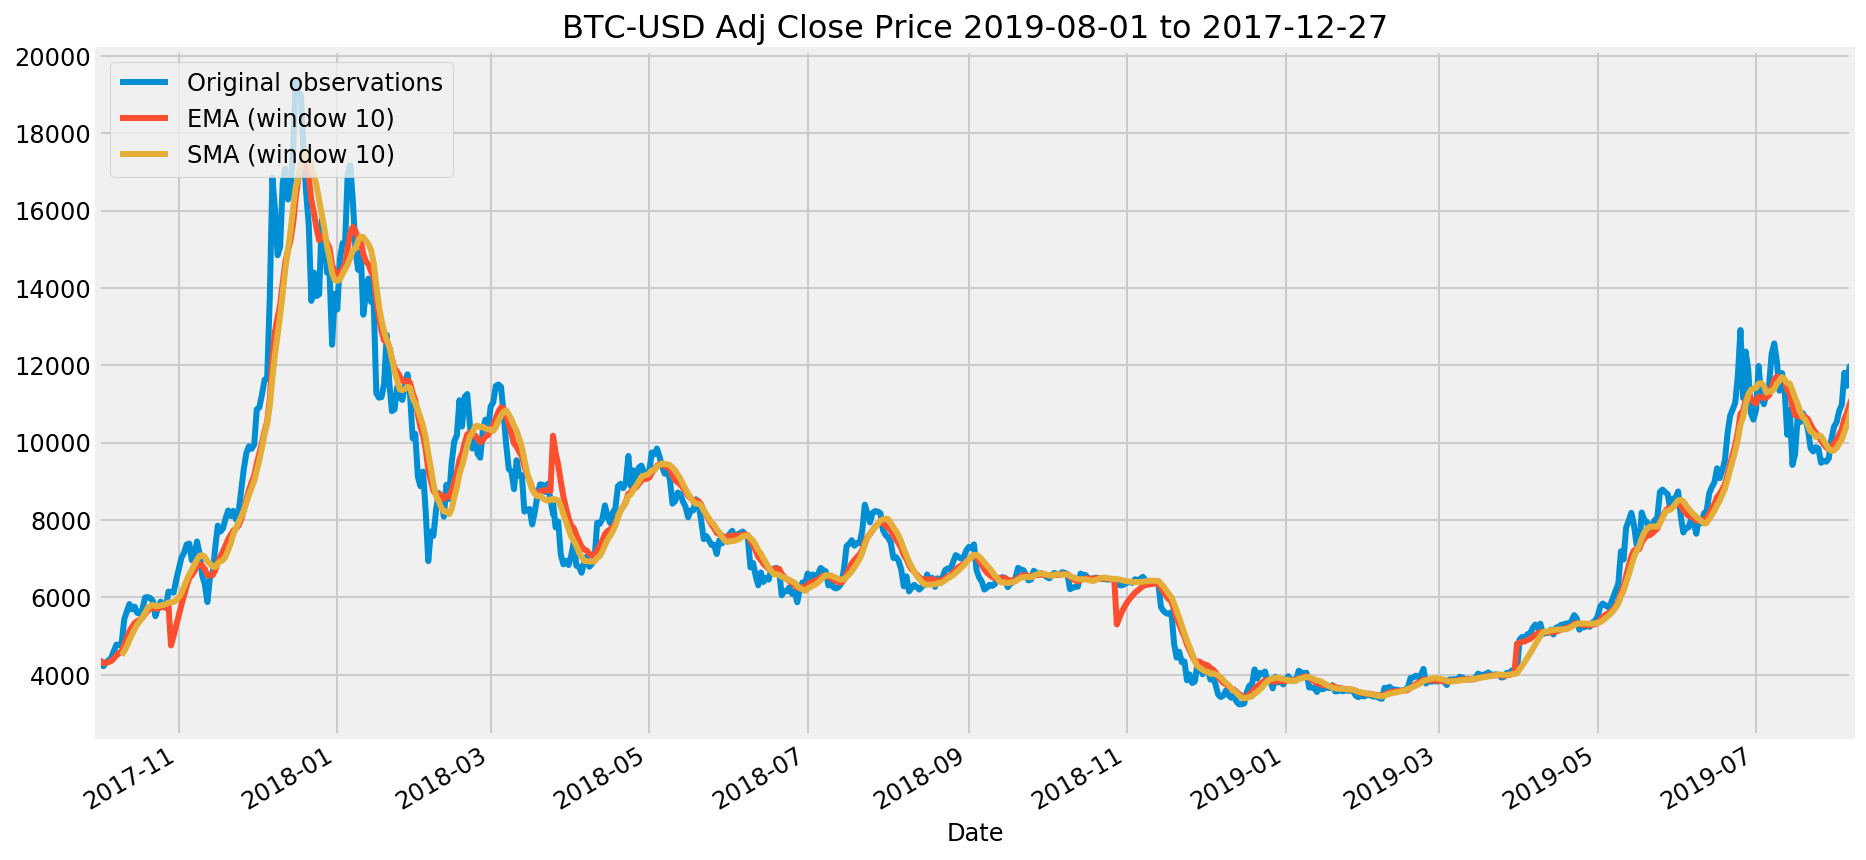

In [20]:
exp_weighted_mean = btc_recent.resample('D').sum().ewm(span=10).mean()
sma_d10 = btc_recent.rolling(window=10).mean()
ax = btc_recent.plot(lw=3, figsize=(14, 7), label='Original observations')
exp_weighted_mean.plot(ax=ax, lw=3, label='EMA (window 10)')
sma_d10.plot(ax=ax, lw=3, label='SMA (window 10)')
plt.title('BTC-USD Adj Close Price 2019-08-01 to 2017-12-27', fontsize=16)
plt.tick_params(labelsize=12)
plt.legend(loc='upper left', fontsize=12)
plt.show()

In [21]:
exp_weighted_mean = btc_recent.resample('D').sum().ewm(span=20).mean()
signals_ema = pd.DataFrame(index=btc_recent.index)
signals_ema['signal'] = 0.0
signals_ema['original'] = btc_recent
signals_ema['EMA'] = exp_weighted_mean
signals_ema['signal'] = np.where(signals_ema['original'] > signals_ema['EMA'], 1.0, 0.0)
signals_ema['positions'] = signals_ema['signal'].diff()

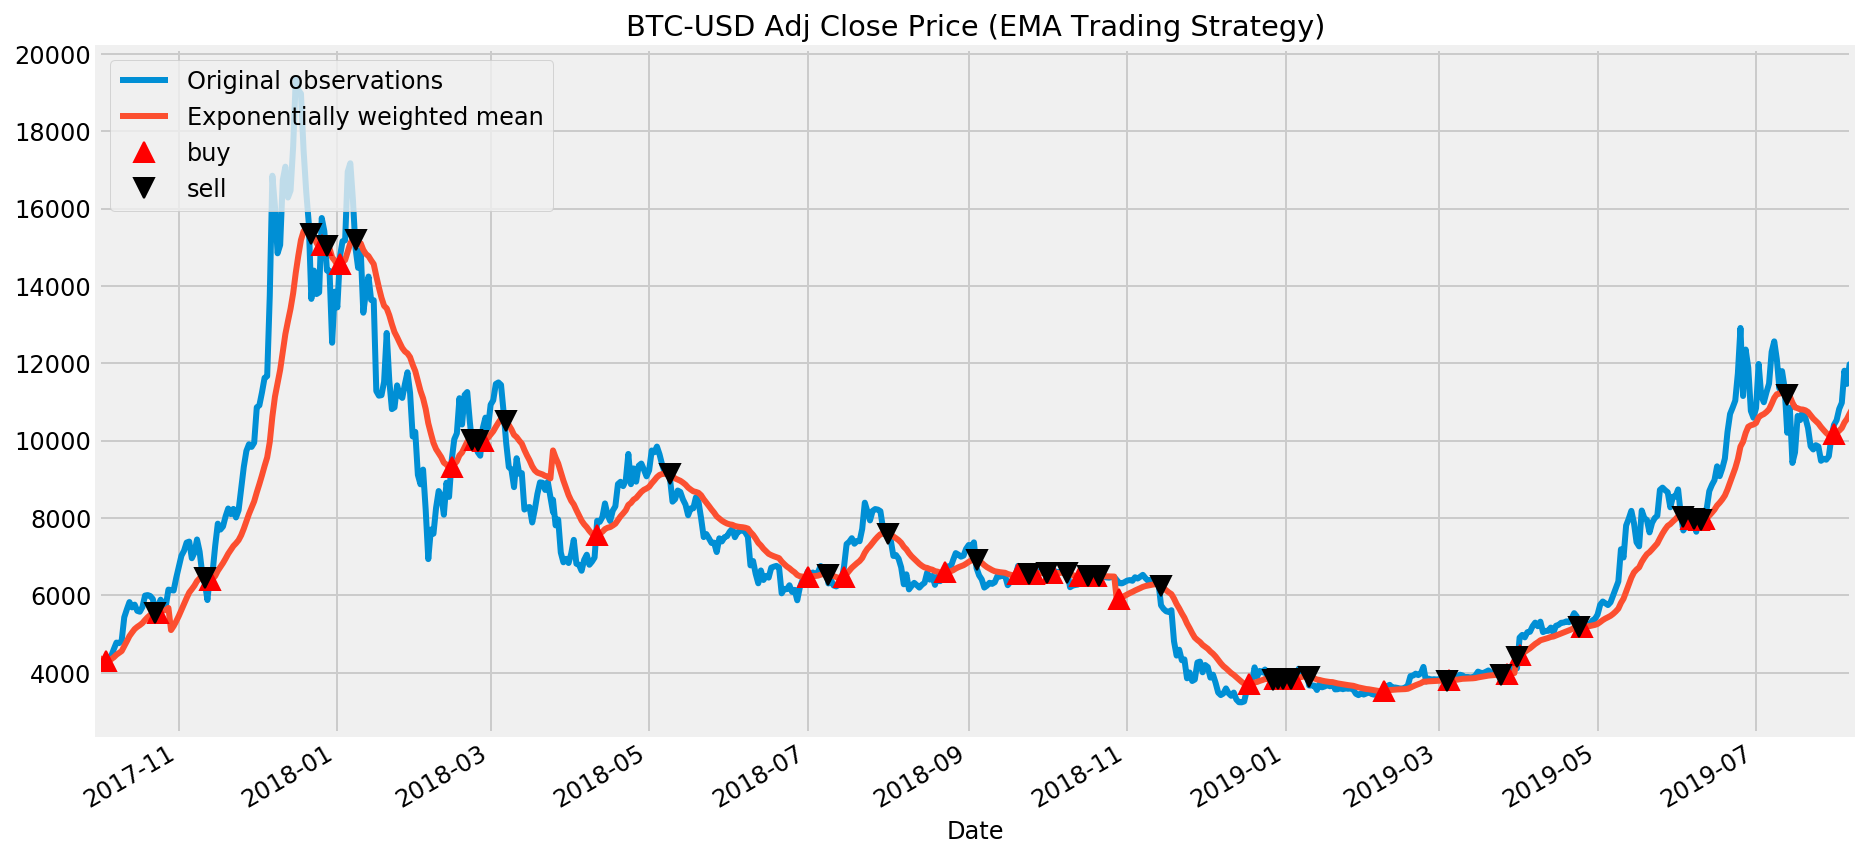

In [22]:
plt.figure(figsize=(14, 7))
ax = btc_recent.plot(lw=3, figsize=(14, 7), label='Original observations')
exp_weighted_mean.plot(ax=ax, lw=3, label='Exponentially weighted mean')
plt.plot(signals_ema.loc[signals_ema.positions == 1.0].index, 
         signals_ema.EMA[signals_ema.positions == 1.0],
         '^', markersize=10, color='r', label='buy')
         
plt.plot(signals_ema.loc[signals_ema.positions == -1.0].index, 
         signals_ema.EMA[signals_ema.positions == -1.0],
         'v', markersize=10, color='k', label='sell')
plt.title('BTC-USD Adj Close Price (EMA Trading Strategy)')
plt.tick_params(labelsize=12)
plt.legend(loc='upper left', fontsize=12)
plt.show()

In [23]:
btc_recent = btc_recent.loc[~btc_recent.index.duplicated(keep='first')]

In [24]:
initial_investment = btc_recent.loc[list(signals_ema[signals_ema.positions == 1.0].index)][0]
bought = np.sum(btc_recent.loc[list(signals_ema[signals_ema.positions == 1.0].index)]*-1.0)
sold = np.sum(btc_recent.loc[list(signals_ema[signals_ema.positions == -1.0].index)])
current_btc_value = btc_recent[-1]
balance_ema = pd.DataFrame([btc_recent.loc[list(signals_ema[signals_ema.positions == 1.0].index)]*-1.0,
              btc_recent.loc[list(signals_ema[signals_ema.positions == -1.0].index)]]).transpose()
balance_ema = balance_ema.fillna(0)
balance_ema['balance'] = balance_ema.sum(axis=1)
print("Initial investment amount: {0:.2f} USD".format(initial_investment))
print("Maximum invested amount: {0:.2f} USD".format(abs(min(balance_ema.cumsum().balance))))
print("Current asset value: {0:.2f} USD".format(bought+sold+current_btc_value))

Initial investment amount: 4321.44 USD
Maximum invested amount: 7171.97 USD
Current asset value: 13423.17 USD
